<a href="https://colab.research.google.com/github/jacobholmshaw/biological-image-classification/blob/main/augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

The current colab version of imgaug does not include cutout and some other functions, so we install the latest version.

Remember to restart runtime after installation.

In [ ]:
pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-rr09kaxu
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-rr09kaxu
  Created wheel for imgaug: filename=imgaug-0.4.0-py3-none-any.whl size=971122 sha256=14930d2edc94c5e41e47ea3918e2ef5c94873bebd1055e93abaee0fdaf24b40e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbvggyih/wheels/0c/78/b5/9303fae9d5e03df1f319adfe4e6534180b5c3232de11bc9a2f
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


## Importing libraries

In [ ]:
import tensorflow as tf  # version 2.5
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, Activation
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, SGD, Ftrl, Nadam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf
import imgaug as ia
import numpy as np
import matplotlib.pyplot as plt
import PIL
from google.colab import drive
from pathlib import Path
from tensorflow.keras import layers
from imgaug import augmenters as iaa
import imageio
from PIL import Image
import os, sys
import random
import cv2
import imutils
from datetime import datetime
from keras import regularizers

## Mounting drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

os.chdir(os.getcwd()+'/drive/MyDrive/Hypothalamus machine learning/Data')
path = os.getcwd()

## Setting path

path is the path that contains all the data.

DATADIR is the directory with the labelled data.

In [ ]:
path = os.getcwd()
DATADIR = path+'/labeled_data'

# The following methods don't work with the DATADIR as a string, therefore we convert it to a path using Path from pathlib
DATADIR = Path(DATADIR)

#Sub directories for different categories
CATEGORIES = ["10_1","10_2","10_3"]

print('Path:', path)
print('Data directory:', DATADIR)

We also define paths for two directories where we save each run of the models (modelDIR) and plots for each plot created from the model run (plotDIR).

In [ ]:
parent = os.path.join(path, os.pardir)
modelDIR = os.path.abspath(parent) + '/Models'
plotDIR = os.path.abspath(parent) + '/Plots/augmentation_acc_loss_plots'
# prints parent directory
print("\nParent Directory:", os.path.abspath(parent))
print("Model directory:", modelDIR)
print("Plots directory:", plotDIR)

In [ ]:
# import zipfile
# !unzip '/test_rot.zip'

In [ ]:
# def create_training_data(directory_name, train = False, val = False, test = False):
#     training_data = []
#     val_data = []
#     test_data = []
#     for category in CATEGORIES:  # 10_1, 10_2, 10_3

#         path = os.path.join(directory_name,category) 
#         class_num = CATEGORIES.index(category)  # get the label  (0, 1 or 2)

#         for img in tqdm.tqdm(os.listdir(path)):  # iterate over each image
#             try:
#                 img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) 
#                 if train == True:
#                   training_data.append([cv2.resize(img_array, (200, 200)), class_num])
#                 if val == True:
#                   val_data.append([cv2.resize(img_array, (200, 200)), class_num])
#                 if test == True:
#                   test_data.append([cv2.resize(img_array, (200, 200)), class_num])
#             except Exception as e:  
#                 pass

#     if train == True:
#       return training_data

#     if val == True:
#       return val_data

#     if test == True:
#       return test_data

# # def data(dir_name, path):
# #   training_data = create_training_data(path + '/{}/train'.format(dir_name), train = True)
# #   val_data = create_training_data(path + '/{}/val'.format(dir_name), val = True)
# #   test_data = create_training_data(path + '/test', test = True)
# #   return training_data, val_data, test_data


In [ ]:
# training_data = create_training_data('test_rot/train', train = True)
# val_data = create_training_data('test_rot/val', val = True)
# test_data = create_training_data(path + '/test', test = True)
# #training_data, val_data, test_data = data(path = 'test_rot', dir_name = '')

To load the saved model

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model(modelDIR + '/rotated_model_29_07_21__10_02')

## Loading functions
We load functions from augfunctions.py which contains 6 useful functions that will be used for testing the augmentations.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Hypothalamus machine learning/Code')
from augfunctions import create_folders, create_directory, create_training_data, data, run_model, visualize

# Aug function

In [ ]:
path_best_model = '19_best_model.h5'

In [ ]:
best_accuracy = 0.0

In [ ]:
from datetime import datetime
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Augmentation function
def augment(augmentation_name,
            start_point = 0.0,
            end_point = 0.0,
            increments = 0.0,
            n_iter = 5,
            rotate = False,
            flip = False,
            Crop = False,
            Shear = False,
            Skew = False,
            Warp = False,
            gBlur = False,
            bright = False,
            sat = False,
            cont = False,
            sp = False,
            cutout = False,
            no_aug = False,
            aug_and_rotate = False,
            earlyStopping = False,
            ):
  val_accuracies = []
  test_accuracies = []
  for i in range(n_iter):

    now = datetime.now()
    save_name = 'augment' + '{}'.format(augmentation_name) + now.strftime("_%d_%m_%Y__%H_%M_%S")


    create_folders(root_dir = path + '/labeled_data', 
                dest_dir = path, 
                val_ratio = 0.15, 
                test_ratio = 0.05)
    create_directory(path = path, 
                  dir_name = save_name)
    sets = ['train', 'val']
    for st in sets:
      for category in CATEGORIES:
        raw_path = os.path.join(path + '/{}'.format(st), category)
        print(raw_path)
        destination_path = os.path.join(os.path.dirname(DATADIR),'{}'.format(save_name) + "/{}".format(st),category)
        print(destination_path)
        for f in os.listdir(raw_path):
            if f.endswith('.jpg'):
                #load image from directory
                image = cv2.imread(os.path.join(raw_path,f), cv2.IMREAD_GRAYSCALE)
                image = cv2.equalizeHist(image)
                fn, fext = os.path.splitext(f)
                
                if no_aug == True:
                  resize = cv2.resize(image,(200,200))
                  cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

                if rotate == True:
                  for angle in np.arange(start_point, end_point, increments):
                    rotated = imutils.rotate_bound(image,angle)
                    resize = cv2.resize(rotated,(200,200))
                    cv2.imwrite(destination_path + '/{}'.format(angle) +'rotated_{}.jpg'.format(fn), resize)

                if flip == True:
                  # Original
                  resize = cv2.resize(image,(200,200))
                  cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

                  # flipping images
                  # flip vertical
                  flipVertical = cv2.flip(image, 0)
                  resize = cv2.resize(flipVertical,(200,200))
                  cv2.imwrite(destination_path +'/vertFlip_{}.jpg'.format(fn), resize)

                  # flip horizontal
                  flipHorizontal = cv2.flip(image, 1)
                  resize = cv2.resize(flipHorizontal,(200,200))
                  cv2.imwrite(destination_path +'/horFlip{}.jpg'.format(fn), resize)

                  # flip both
                  flipBoth = cv2.flip(image, -1)
                  resize = cv2.resize(flipBoth,(200,200))
                  cv2.imwrite(destination_path +'/bothFlip_{}.jpg'.format(fn), resize)

                if Crop == True:
                  for percentage in np.arange(start_point, end_point, increments):
                    crop = iaa.Crop(percent = percentage, keep_size = True)
                    image_aug = crop(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 20):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(percentage) +'rotated_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(percentage) + 'crop{}.jpg'.format(fn), resize)

                if Shear == True:
                  for num in np.arange(start_point, end_point, increments):
                    shear = iaa.ShearX(num)
                    image_aug = shear(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotated_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'shearX{}.jpg'.format(fn), resize)

                    shear2 = iaa.ShearY(num)
                    image_aug2 = shear(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize2 = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotated_{}.jpg'.format(fn), resize2)
                    else:
                      resize2 = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'shearY{}.jpg'.format(fn), resize2)
                    

                if gBlur == True:
                  for num in np.arange(start_point, end_point, increments):
                    gblur = iaa.GaussianBlur(sigma = num)
                    image_aug = gblur(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 20):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotatedblur_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'blur{}.jpg'.format(fn), resize)

                if bright == True:
                  for brightness in np.arange(start_point, end_point, increments):
                    brighten = iaa.MultiplyBrightness(brightness)
                    brightened = brighten(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(brightened ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(brightness) +'rotatedbright_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(brightened, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(brightness) + 'bright{}.jpg'.format(fn), resize)

                if sat == True:
                  for saturation in np.arange(start_point, end_point, increments):
                    saturate = iaa.MultiplySaturation(saturation)
                    saturated_img = saturate(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(saturated_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(saturation) +'rotatedsat_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(saturated_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(saturation) + 'sat{}.jpg'.format(fn), resize)

                if cont == True:
                  for contrast in np.arange(start_point, end_point, increments):
                    aug = iaa.GammaContrast(contrast)
                    contrast_img = aug(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(contrast_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(contrast) +'rotatedcont_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(constrast_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(contrast) + 'cont{}.jpg'.format(fn), resize)

                if sp == True:
                  for num in np.arange(start_point, end_point, increments):
                    aug = iaa.SaltAndPepper(num)
                    aug_img = aug(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(aug_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotatedSP_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(aug_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'SP{}.jpg'.format(fn), resize)

                
                if cutout == True:
                  resize = cv2.resize(image,(200,200))
                  cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

                  for i in range(increments):
                    aug = iaa.Cutout()
                    aug_img = aug(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(aug_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(i) +'rotatedcut_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(aug_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(i) + 'cut{}.jpg'.format(fn), resize)

        os.chdir(os.path.join(os.path.dirname(raw_path)))

    training_data, val_data, test_data = data(path = path,
                                dir_name = save_name)

    random.shuffle(training_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    # Preprocessing the data into X_train etc with relevant input shapes
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    img_size = 200

    for feature, label in training_data:
      X_train.append(feature)
      y_train.append(label)

    for feature, label in val_data:
      X_val.append(feature)
      y_val.append(label)

    for feature, label in test_data:
      X_test.append(feature)
      y_test.append(label)

    X_train = np.array(X_train) / 255
    X_val = np.array(X_val) / 255
    X_test = np.array(X_test) / 255

    X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
    X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
    X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

    X_train.astype('float32')
    X_val.astype('float32')
    X_test.astype('float32')

    y_train=to_categorical(y_train)
    y_val=to_categorical(y_val)
    y_test = to_categorical(y_test)

    print('X_train shape should be:', 0.7*(len(training_data) + len(test_data) + len(val_data)))
    print('X_train shape:', np.shape(X_train))
    print('X_val and X_test shapes should be:', 0.15*(len(training_data) + len(test_data) + len(val_data)))
    print('X_val shape:', np.shape(X_val))
    print('X_test shape:', np.shape(X_test))
    print('y_train shape:', np.shape(y_train))
    print('y_val shape:', np.shape(y_val))
    print('y_test shape:', np.shape(y_test))

    layer_drop = 0.07154743824929628
    final_drop = 0.9226848150860136
    lamda = 1.1209101215526163e-06
    activation = 'relu'
    model = Sequential([
      layers.Conv2D(16, 3, 
                    padding='same', 
                    activation=activation, 
                    input_shape = (200, 200, 1), 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-1'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-2'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda),
                    name = 'conv-layer-3'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-4'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(256, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-5'),
      layers.Dropout(layer_drop),
      layers.Conv2D(512, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-6'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(final_drop),
      layers.Dense(3, activation = 'softmax')
    ])

    optimizer = Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    epochs = 50
    if earlyStopping == True:
      earlyStop = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10)

      history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks = [earlyStop])
      if earlyStop.stopped_epoch < epochs:
        epochs_range = range(earlyStop.stopped_epoch+1)

    else:
      history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val))
      epochs_range = range(epochs)


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['val_accuracy'][-1]

    # Test accuracy
    test_acc = model.evaluate(X_test, y_test)[1]

    # if callback.stopped_epoch < epochs:
    #   epochs_range = range(callback.stopped_epoch + 1)
    # else:
    #   epochs_range = range(epochs)


    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy = {}%'.format(round(np.mean(acc[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.plot(epochs_range, val_acc, label='Validation Accuracy = {}%'.format(round(np.mean(val_acc[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss = {}%'.format(round(np.mean(loss[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.plot(epochs_range, val_loss, label='Validation Loss = {}%'.format(round(np.mean(val_loss[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.figtext(0.425, 0.08, 'Training size = {}'.format(np.shape(X_train)[0]))
    plt.figtext(0.425, 0.06, 'Validation size = {}'.format(np.shape(X_val)[0]))
    plt.figtext(0.425, 0.04, 'Test accuracy = {}%'.format(round(test_acc*100, 1)))
    plt.savefig(plotDIR + '/{}.png'.format(save_name))
    print('Saved plot as `{}`.png'.format(save_name))
    plt.show()

    val_accuracies.append(round(np.mean(val_acc[max(epochs_range) - 5:max(epochs_range)])*100, 1))
    test_accuracies.append(model.evaluate(X_test, y_test)[1])

    # if accuracy > best_accuracy:

    #     model.save(path_best_model)

    #     best_accuracy = accuracy

    model.save(modelDIR + '/{}'.format(save_name))
    print('Saved model as `{}`'.format(save_name))

    del model

    K.clear_session()
  
  print('Average validation accuracy:', np.mean(val_accuracies))
  print('Average test accuracy:', np.mean(test_accuracies))



# Second augmentation function (testing combinations)

In [ ]:
def log_dir(rotate = False,
            flip = False,
            Crop = False,
            Shear = False,
            Skew = False,
            Warp = False,
            gBlur = False,
            bright = False,
            sat = False,
            cont = False,
            sp = False,
            cutout = False,
            no_aug = False,
            aug_and_rotate = False,
            earlyStopping = False,
            ):
  
  s = '/content/drive/MyDrive/Hypothalamus machine learning/Data/{}/{}/{}'.format(save_name, category, fn)

  if rotate == True:
    s = s + '_rotate_{}'.format(angle)
  
  if flip == True:

  if Crop == True:
    s = s + '_crop_{}'.format(percentage)

  

  s = s + '.jpg'

  return s



In [ ]:
from datetime import datetime
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Augmentation function
def augment(augmentation_name,
            start_point = 0.0,
            end_point = 0.0,
            increments = 0.0,
            n_iter = 5,
            rotate = False,
            flip = False,
            Crop = False,
            Shear = False,
            Skew = False,
            Warp = False,
            gBlur = False,
            bright = False,
            sat = False,
            cont = False,
            sp = False,
            cutout = False,
            no_aug = False,
            aug_and_rotate = False,
            earlyStopping = False,
            ):
  val_accuracies = []
  test_accuracies = []
  for i in range(n_iter):

    now = datetime.now()
    save_name = 'augment' + '{}'.format(augmentation_name) + now.strftime("_%d_%m_%Y__%H_%M_%S")


    create_folders(root_dir = path + '/labeled_data', 
                dest_dir = path, 
                val_ratio = 0.15, 
                test_ratio = 0.05)
    create_directory(path = path, 
                  dir_name = save_name)
    sets = ['train', 'val']
    for st in sets:
      for category in CATEGORIES:
        raw_path = os.path.join(path + '/{}'.format(st), category)
        print(raw_path)
        destination_path = os.path.join(os.path.dirname(DATADIR),'{}'.format(save_name) + "/{}".format(st),category)
        print(destination_path)
        for f in os.listdir(raw_path):
            if f.endswith('.jpg'):
                #load image from directory
                image = cv2.imread(os.path.join(raw_path,f), cv2.IMREAD_GRAYSCALE)
                fn, fext = os.path.splitext(f)
                
                if no_aug == True:
                  resize = cv2.resize(image,(200,200))
                  #cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

                if rotate == True:
                  for angle in np.arange(start_point, end_point, increments):
                    rotated = imutils.rotate_bound(image,angle)
                    resize = cv2.resize(rotated,(200,200))
                    #cv2.imwrite(destination_path + '/{}'.format(angle) +'rotated_{}.jpg'.format(fn), resize)

                if flip == True:
                  # Original
                  resize = cv2.resize(image,(200,200))
                  cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

                  # flipping images
                  # flip vertical
                  flipVertical = cv2.flip(image, 0)
                  resize = cv2.resize(flipVertical,(200,200))
                  cv2.imwrite(destination_path +'/vertFlip_{}.jpg'.format(fn), resize)

                  # flip horizontal
                  flipHorizontal = cv2.flip(image, 1)
                  resize = cv2.resize(flipHorizontal,(200,200))
                  cv2.imwrite(destination_path +'/horFlip{}.jpg'.format(fn), resize)

                  # flip both
                  flipBoth = cv2.flip(image, -1)
                  resize = cv2.resize(flipBoth,(200,200))
                  cv2.imwrite(destination_path +'/bothFlip_{}.jpg'.format(fn), resize)

                if Crop == True:
                  for percentage in np.arange(start_point, end_point, increments):
                    crop = iaa.Crop(percent = percentage, keep_size = True)
                    image_aug = crop(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 20):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(percentage) +'rotated_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(percentage) + 'crop{}.jpg'.format(fn), resize)

                if Shear == True:
                  for num in np.arange(start_point, end_point, increments):
                    shear = iaa.ShearX(num)
                    image_aug = shear(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotated_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'shearX{}.jpg'.format(fn), resize)

                    shear2 = iaa.ShearY(num)
                    image_aug2 = shear(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize2 = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotated_{}.jpg'.format(fn), resize2)
                    else:
                      resize2 = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'shearY{}.jpg'.format(fn), resize2)
                    

                if gBlur == True:
                  for num in np.arange(start_point, end_point, increments):
                    gblur = iaa.GaussianBlur(sigma = num)
                    image_aug = gblur(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(image_aug ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotatedblur_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(image_aug, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'blur{}.jpg'.format(fn), resize)

                if bright == True:
                  for brightness in np.arange(start_point, end_point, increments):
                    brighten = iaa.MultiplyBrightness(brightness)
                    brightened = brighten(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(brightened ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(brightness) +'rotatedbright_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(brightened, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(brightness) + 'bright{}.jpg'.format(fn), resize)

                if sat == True:
                  for saturation in np.arange(start_point, end_point, increments):
                    saturate = iaa.MultiplySaturation(saturation)
                    saturated_img = saturate(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(saturated_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(saturation) +'rotatedsat_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(saturated_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(saturation) + 'sat{}.jpg'.format(fn), resize)

                if cont == True:
                  for contrast in np.arange(start_point, end_point, increments):
                    aug = iaa.GammaContrast(contrast)
                    contrast_img = aug(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(contrast_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(contrast) +'rotatedcont_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(constrast_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(contrast) + 'cont{}.jpg'.format(fn), resize)

                if sp == True:
                  for num in np.arange(start_point, end_point, increments):
                    aug = iaa.SaltAndPepper(num)
                    aug_img = aug(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(aug_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotatedSP_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(aug_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(num) + 'SP{}.jpg'.format(fn), resize)

                
                if cutout == True:
                  resize = cv2.resize(image,(200,200))
                  cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

                  for i in range(increments):
                    aug = iaa.Cutout()
                    aug_img = aug(image = image)
                    if aug_and_rotate == True:
                      for angle in np.arange(0, 360, 5):
                        aug = imutils.rotate_bound(aug_img ,angle)
                        resize = cv2.resize(aug,(200,200))
                        cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(i) +'rotatedcut_{}.jpg'.format(fn), resize)
                    else:
                      resize = cv2.resize(aug_img, (200, 200))
                      cv2.imwrite(destination_path + '/{}'.format(i) + 'cut{}.jpg'.format(fn), resize)

        os.chdir(os.path.join(os.path.dirname(raw_path)))

    training_data, val_data, test_data = data(path = path,
                                dir_name = save_name)

    random.shuffle(training_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    # Preprocessing the data into X_train etc with relevant input shapes
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    img_size = 200

    for feature, label in training_data:
      X_train.append(feature)
      y_train.append(label)

    for feature, label in val_data:
      X_val.append(feature)
      y_val.append(label)

    for feature, label in test_data:
      X_test.append(feature)
      y_test.append(label)

    X_train = np.array(X_train) / 255
    X_val = np.array(X_val) / 255
    X_test = np.array(X_test) / 255

    X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
    X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
    X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

    X_train.astype('float32')
    X_val.astype('float32')
    X_test.astype('float32')

    y_train=to_categorical(y_train)
    y_val=to_categorical(y_val)
    y_test = to_categorical(y_test)

    print('X_train shape should be:', 0.7*(len(training_data) + len(test_data) + len(val_data)))
    print('X_train shape:', np.shape(X_train))
    print('X_val and X_test shapes should be:', 0.15*(len(training_data) + len(test_data) + len(val_data)))
    print('X_val shape:', np.shape(X_val))
    print('X_test shape:', np.shape(X_test))
    print('y_train shape:', np.shape(y_train))
    print('y_val shape:', np.shape(y_val))
    print('y_test shape:', np.shape(y_test))

    layer_drop = 0.07154743824929628
    final_drop = 0.9226848150860136
    lamda = 1.1209101215526163e-06
    activation = 'relu'
    model = Sequential([
      layers.Conv2D(16, 3, 
                    padding='same', 
                    activation=activation, 
                    input_shape = (200, 200, 1), 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-1'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-2'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda),
                    name = 'conv-layer-3'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-4'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Conv2D(256, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-5'),
      layers.Dropout(layer_drop),
      layers.Conv2D(512, 3, 
                    padding='same', 
                    activation=activation, 
                    kernel_regularizer=regularizers.l2(lamda), 
                    name = 'conv-layer-6'),
      layers.Dropout(layer_drop),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(final_drop),
      layers.Dense(3, activation = 'softmax')
    ])

    optimizer = Adam(learning_rate = 0.0000020465927460995575)
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    epochs = 50
    if earlyStopping == True:
      earlyStop = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10)

      history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks = [earlyStop])
      if earlyStop.stopped_epoch < epochs:
        epochs_range = range(earlyStop.stopped_epoch+1)

    else:
      history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(X_val, y_val))
      epochs_range = range(epochs)


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['val_accuracy'][-1]

    # Test accuracy
    test_acc = model.evaluate(X_test, y_test)[1]

    # if callback.stopped_epoch < epochs:
    #   epochs_range = range(callback.stopped_epoch + 1)
    # else:
    #   epochs_range = range(epochs)


    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy = {}%'.format(round(np.mean(acc[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.plot(epochs_range, val_acc, label='Validation Accuracy = {}%'.format(round(np.mean(val_acc[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss = {}%'.format(round(np.mean(loss[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.plot(epochs_range, val_loss, label='Validation Loss = {}%'.format(round(np.mean(val_loss[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.figtext(0.425, 0.08, 'Training size = {}'.format(np.shape(X_train)[0]))
    plt.figtext(0.425, 0.06, 'Validation size = {}'.format(np.shape(X_val)[0]))
    plt.figtext(0.425, 0.04, 'Test accuracy = {}%'.format(round(test_acc*100, 1)))
    plt.savefig(plotDIR + '/{}.png'.format(save_name))
    print('Saved plot as `{}`.png'.format(save_name))
    plt.show()

    val_accuracies.append(round(np.mean(val_acc[max(epochs_range) - 5:max(epochs_range)])*100, 1))
    test_accuracies.append(model.evaluate(X_test, y_test)[1])

    # if accuracy > best_accuracy:

    #     model.save(path_best_model)

    #     best_accuracy = accuracy

    model.save(modelDIR + '/{}'.format(save_name))
    print('Saved model as `{}`'.format(save_name))

    del model

    K.clear_session()
  
  print('Average validation accuracy:', np.mean(val_accuracies))
  print('Average test accuracy:', np.mean(test_accuracies))



# No augmentation results

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentno_aug_23_08_2021__11_39_20 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentno_aug_23_08_2021__11_39_20/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentno_aug_23_08_2021__11_39_20/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus ma

100%|██████████| 3/3 [00:00<00:00, 106.59it/s]


X_train shape should be: 105.69999999999999
X_train shape: (119, 200, 200, 1)
X_val and X_test shapes should be: 22.65
X_val shape: (23, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (119, 3)
y_val shape: (23, 3)
y_test shape: (9, 3)
Epoch 1/50
4/4 [==============================] - 2s 190ms/step - loss: 1.0980 - accuracy: 0.3025 - val_loss: 1.0953 - val_accuracy: 0.3913
Epoch 2/50
4/4 [==============================] - 0s 31ms/step - loss: 1.1073 - accuracy: 0.3277 - val_loss: 1.0908 - val_accuracy: 0.3913
Epoch 3/50
4/4 [==============================] - 0s 31ms/step - loss: 1.0765 - accuracy: 0.3529 - val_loss: 1.0890 - val_accuracy: 0.3913
Epoch 4/50
4/4 [==============================] - 0s 32ms/step - loss: 1.0902 - accuracy: 0.3697 - val_loss: 1.0876 - val_accuracy: 0.3913
Epoch 5/50
4/4 [==============================] - 0s 32ms/step - loss: 1.1217 - accuracy: 0.3277 - val_loss: 1.0886 - val_accuracy: 0.3913
Epoch 6/50
4/4 [==============================] - 0s 31ms

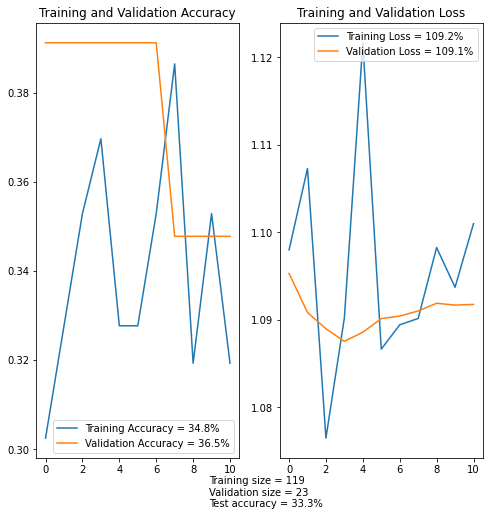

1/1 [==============================] - 0s 18ms/step - loss: 1.1046 - accuracy: 0.3333


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentno_aug_23_08_2021__11_39_20/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentno_aug_23_08_2021__11_39_20/assets


Saved model as `augmentno_aug_23_08_2021__11_39_20`
Average validation accuracy: 36.5
Average test accuracy: 0.3333333432674408


In [ ]:
augment('no_aug', no_aug = True, earlyStopping = True, n_iter = 1)

# Rotation results

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentrotate2_23_08_2021__11_40_03 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentrotate2_23_08_2021__11_40_03/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentrotate2_23_08_2021__11_40_03/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus

100%|██████████| 3/3 [00:00<00:00, 86.43it/s]


X_train shape should be: 304.5
X_train shape: (357, 200, 200, 1)
X_val and X_test shapes should be: 65.25
X_val shape: (69, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (357, 3)
y_val shape: (69, 3)
y_test shape: (9, 3)
Epoch 1/50
12/12 [==============================] - 1s 56ms/step - loss: 1.1245 - accuracy: 0.3109 - val_loss: 1.0924 - val_accuracy: 0.3623
Epoch 2/50
12/12 [==============================] - 0s 27ms/step - loss: 1.1043 - accuracy: 0.3333 - val_loss: 1.0951 - val_accuracy: 0.3478
Epoch 3/50
12/12 [==============================] - 0s 27ms/step - loss: 1.1077 - accuracy: 0.3529 - val_loss: 1.0949 - val_accuracy: 0.3478
Epoch 4/50
12/12 [==============================] - 0s 27ms/step - loss: 1.0979 - accuracy: 0.3473 - val_loss: 1.0925 - val_accuracy: 0.3333
Epoch 5/50
12/12 [==============================] - 0s 28ms/step - loss: 1.1005 - accuracy: 0.3473 - val_loss: 1.0936 - val_accuracy: 0.3478
Epoch 6/50
12/12 [==============================] - 0s 27ms/s

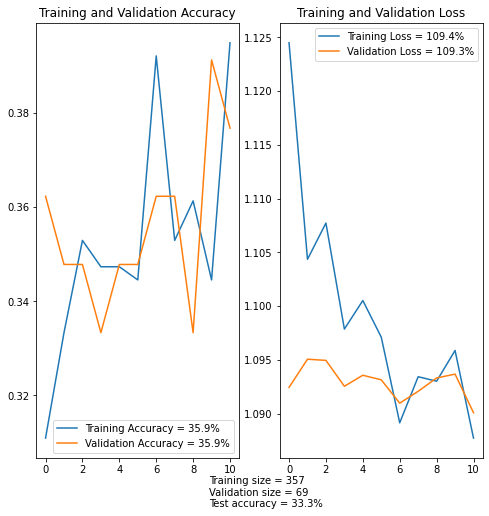

1/1 [==============================] - 0s 18ms/step - loss: 1.1055 - accuracy: 0.3333


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentrotate2_23_08_2021__11_40_03/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentrotate2_23_08_2021__11_40_03/assets


Saved model as `augmentrotate2_23_08_2021__11_40_03`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Total images:  55
Training:  43
Validation:  9
Testing:  3
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-454865168de3>", line 1, in <module>
    augment('rotate2', rotate = True, earlyStopping=True, start_point= 0, end_point=355, increments=360/3)
  File "<ipython-input-25-e4efa4c1f43e>", line 37, in augment
    test_ratio = 0.05)
  File "/content/drive/MyDrive/Hypothalamus machine learning/Code/augfunctions.py", line 111, in create_folders
    shutil.copy(name, dest_dir +'/train' + cls)
  File "/usr/lib/python3.7/shutil.py", line 248, in copy
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib/python3.7/shutil.py", line 122, in copyfile
    copyfileobj(fsrc, fdst)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

KeyboardInterrupt: ignored

In [ ]:
augment('rotate2', rotate = True, earlyStopping=True, start_point= 0, end_point=355, increments=360/3)

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/rotate/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/rotate/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/rotate/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3

100%|██████████| 3/3 [00:00<00:00, 81.90it/s]


X_train shape should be: 7163.099999999999
X_train shape: (8568, 200, 200, 1)
X_val and X_test shapes should be: 1534.95
X_val shape: (1656, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8568, 3)
y_val shape: (1656, 3)
y_test shape: (9, 3)
Epoch 1/50
268/268 [==============================] - 24s 29ms/step - loss: 1.1565 - accuracy: 0.3768 - val_loss: 1.1601 - val_accuracy: 0.3345
Epoch 2/50
268/268 [==============================] - 7s 27ms/step - loss: 1.1413 - accuracy: 0.4008 - val_loss: 1.1515 - val_accuracy: 0.4082
Epoch 3/50
268/268 [==============================] - 7s 26ms/step - loss: 1.1264 - accuracy: 0.4267 - val_loss: 1.1458 - val_accuracy: 0.4106
Epoch 4/50
268/268 [==============================] - 7s 26ms/step - loss: 1.1135 - accuracy: 0.4488 - val_loss: 1.1369 - val_accuracy: 0.3889
Epoch 5/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0997 - accuracy: 0.4712 - val_loss: 1.1299 - val_accuracy: 0.4173
Epoch 6/50
268/268 [==========

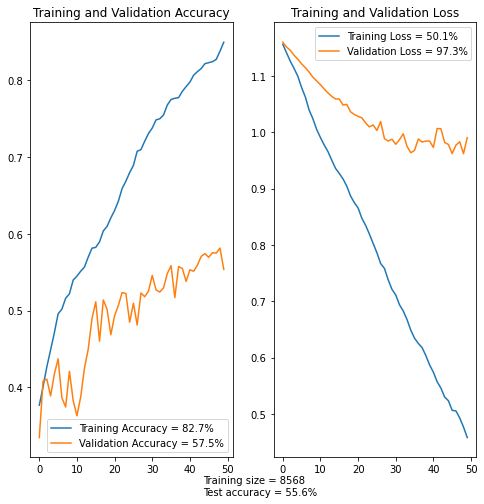

UnboundLocalError: ignored

In [ ]:
augment('rotate', rotate = True)

# Crop results

In [ ]:
now = datetime.now()
augmentation_name = 'crop_test'
save_name = 'augment' + '{}'.format(augmentation_name) + now.strftime("_%d_%m_%Y__%H_%M_%S")


create_folders(root_dir = path + '/labeled_data', 
            dest_dir = path, 
            val_ratio = 0.15, 
            test_ratio = 0.05)
create_directory(path = path, 
              dir_name = save_name)
sets = ['train', 'val']
for st in sets:
  for category in CATEGORIES:
    raw_path = os.path.join(path + '/{}'.format(st), category)
    print(raw_path)
    destination_path = os.path.join(os.path.dirname(DATADIR),'{}'.format(save_name) + "/{}".format(st),category)
    print(destination_path)
    for f in os.listdir(raw_path):
        if f.endswith('.jpg'):
            #load image from directory
            image = cv2.imread(os.path.join(raw_path,f), cv2.IMREAD_GRAYSCALE)
            image = cv2.equalizeHist(image)
            fn, fext = os.path.splitext(f)
            for percentage in np.arange(0, 0.3, 0.15):
              crop = iaa.Crop(percent = percentage, keep_size = True)
              image_aug = crop(image = image)
              for angle in np.arange(0, 340, 20):
                aug = imutils.rotate_bound(image_aug ,angle)
                resize = cv2.resize(aug,(200,200))
                cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(percentage) +'rotated_{}.jpg'.format(fn), resize)

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



no augmentcrop_test_23_08_2021__10_31_58 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcrop_test_23_08_2021__10_31_58/train/10_1
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-53423b678520>", line 29, in <module>
    aug = imutils.rotate_bound(image_aug ,angle)
  File "/usr/local/lib/python3.7/dist-packages/imutils/convenience.py", line 63, in rotate_bound
    return cv2.warpAffine(image, M, (nW, nH))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in

KeyboardInterrupt: ignored

In [ ]:
training_data, val_data, test_data = data(path = path,
                            dir_name = save_name)

random.shuffle(training_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Preprocessing the data into X_train etc with relevant input shapes
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
img_size = 200

for feature, label in training_data:
  X_train.append(feature)
  y_train.append(label)

for feature, label in val_data:
  X_val.append(feature)
  y_val.append(label)

for feature, label in test_data:
  X_test.append(feature)
  y_test.append(label)

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

X_train.astype('float32')
X_val.astype('float32')
X_test.astype('float32')

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test = to_categorical(y_test)

print('X_train shape:', np.shape(X_train))
print('X_val shape:', np.shape(X_val))
print('X_test shape:', np.shape(X_test))
print('y_train shape:', np.shape(y_train))
print('y_val shape:', np.shape(y_val))
print('y_test shape:', np.shape(y_test))

100%|██████████| 3/3 [00:00<00:00, 146.41it/s]


X_train shape: (4284, 200, 200, 1)
X_val shape: (828, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (4284, 3)
y_val shape: (828, 3)
y_test shape: (9, 3)


In [ ]:
layer_drop = 0.07154743824929628
final_drop = 0.9226848150860136
lamda = 1.1209101215526163e-06
activation = 'relu'
model = Sequential([
  layers.Conv2D(16, 3, 
                padding='same', 
                activation=activation, 
                input_shape = (200, 200, 1), 
                kernel_regularizer=regularizers.l2(lamda), 
                name = 'conv-layer-1'),
  layers.Dropout(layer_drop),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, 
                padding='same', 
                activation=activation, 
                kernel_regularizer=regularizers.l2(lamda), 
                name = 'conv-layer-2'),
  layers.Dropout(layer_drop),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, 
                padding='same', 
                activation=activation, 
                kernel_regularizer=regularizers.l2(lamda),
                name = 'conv-layer-3'),
  layers.Dropout(layer_drop),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, 
                padding='same', 
                activation=activation, 
                kernel_regularizer=regularizers.l2(lamda), 
                name = 'conv-layer-4'),
  layers.Dropout(layer_drop),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, 
                padding='same', 
                activation=activation, 
                kernel_regularizer=regularizers.l2(lamda), 
                name = 'conv-layer-5'),
  layers.Dropout(layer_drop),
  layers.Conv2D(512, 3, 
                padding='same', 
                activation=activation, 
                kernel_regularizer=regularizers.l2(lamda), 
                name = 'conv-layer-6'),
  layers.Dropout(layer_drop),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(final_drop),
  layers.Dense(3, activation = 'softmax')
])

optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 50
if earlyStopping == True:
  earlyStop = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10)

  history = model.fit(x=X_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks = [earlyStop])
  if earlyStop.stopped_epoch < epochs:
    epochs_range = range(earlyStop.stopped_epoch+1)

# Gaussian blur results

Text(0.725, 0.15, 'Blur level 20')

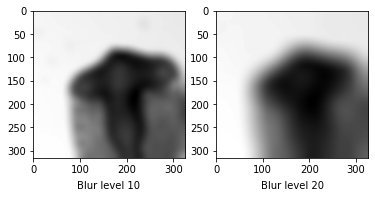

In [ ]:
og = cv2.imread(path + '/labeled_data/10_3/10.3_039.jpg', cv2.IMREAD_GRAYSCALE)
blur10 = iaa.GaussianBlur(10)
blur20 = iaa.GaussianBlur(25)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(blur10(image = og), cmap = 'gray')
f.text(0.3,0.15, 'Blur level 10', ha = 'center', va = 'center')
axarr[1].imshow(blur20(image = og), cmap = 'gray')
f.text(0.725,0.15, 'Blur level 20', ha = 'center', va = 'center')
#plt.savefig(os.path.abspath(parent) + '/image_plots/blur.png')

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_23_08_2021__10_41_30 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_41_30/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_41_30/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus ma

100%|██████████| 3/3 [00:00<00:00, 107.05it/s]


X_train shape should be: 3584.7
X_train shape: (4284, 200, 200, 1)
X_val and X_test shapes should be: 768.15
X_val shape: (828, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (4284, 3)
y_val shape: (828, 3)
y_test shape: (9, 3)
Epoch 1/50
134/134 [==============================] - 65s 482ms/step - loss: 1.0963 - accuracy: 0.3581 - val_loss: 1.0932 - val_accuracy: 0.3949
Epoch 2/50
134/134 [==============================] - 4s 27ms/step - loss: 1.0945 - accuracy: 0.3702 - val_loss: 1.0934 - val_accuracy: 0.3720
Epoch 3/50
134/134 [==============================] - 4s 27ms/step - loss: 1.0891 - accuracy: 0.3623 - val_loss: 1.0870 - val_accuracy: 0.3684
Epoch 4/50
134/134 [==============================] - 4s 27ms/step - loss: 1.0845 - accuracy: 0.3758 - val_loss: 1.0841 - val_accuracy: 0.3394
Epoch 5/50
134/134 [==============================] - 4s 27ms/step - loss: 1.0723 - accuracy: 0.3994 - val_loss: 1.0626 - val_accuracy: 0.4384
Epoch 6/50
134/134 [=======================

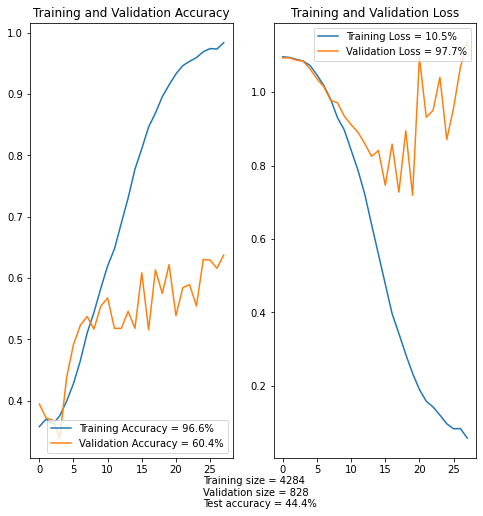

1/1 [==============================] - 0s 19ms/step - loss: 7.7717 - accuracy: 0.4444


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_41_30/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_41_30/assets


Saved model as `augmentgBlur2_23_08_2021__10_41_30`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_23_08_2021__10_45_45 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_45_45/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_45_45/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 73.23it/s]


X_train shape should be: 3584.7
X_train shape: (4284, 200, 200, 1)
X_val and X_test shapes should be: 768.15
X_val shape: (828, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (4284, 3)
y_val shape: (828, 3)
y_test shape: (9, 3)
Epoch 1/50
134/134 [==============================] - 5s 30ms/step - loss: 1.0985 - accuracy: 0.3634 - val_loss: 1.0913 - val_accuracy: 0.3816
Epoch 2/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0897 - accuracy: 0.3718 - val_loss: 1.0876 - val_accuracy: 0.4155
Epoch 3/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0793 - accuracy: 0.3875 - val_loss: 1.0883 - val_accuracy: 0.4457
Epoch 4/50
134/134 [==============================] - 4s 27ms/step - loss: 1.0585 - accuracy: 0.3987 - val_loss: 1.0597 - val_accuracy: 0.4312
Epoch 5/50
134/134 [==============================] - 4s 27ms/step - loss: 1.0316 - accuracy: 0.4449 - val_loss: 1.0360 - val_accuracy: 0.4819
Epoch 6/50
134/134 [=========================

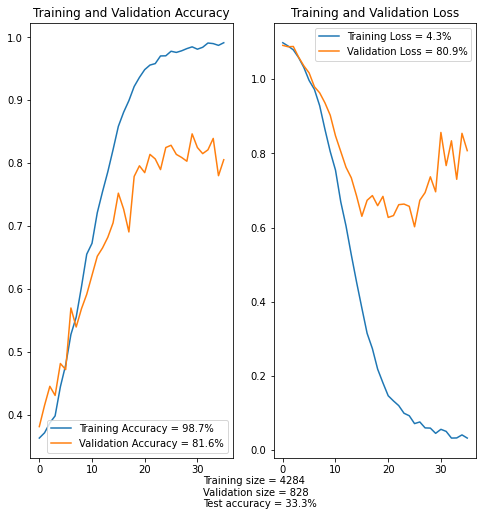

1/1 [==============================] - 0s 19ms/step - loss: 2.0388 - accuracy: 0.3333


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_45_45/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_45_45/assets


Saved model as `augmentgBlur2_23_08_2021__10_45_45`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_23_08_2021__10_49_39 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_49_39/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_49_39/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 63.18it/s]


X_train shape should be: 3584.7
X_train shape: (4284, 200, 200, 1)
X_val and X_test shapes should be: 768.15
X_val shape: (828, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (4284, 3)
y_val shape: (828, 3)
y_test shape: (9, 3)
Epoch 1/50
134/134 [==============================] - 5s 31ms/step - loss: 1.1000 - accuracy: 0.3541 - val_loss: 1.0948 - val_accuracy: 0.3913
Epoch 2/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0947 - accuracy: 0.3646 - val_loss: 1.0854 - val_accuracy: 0.3913
Epoch 3/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0930 - accuracy: 0.3618 - val_loss: 1.0873 - val_accuracy: 0.4529
Epoch 4/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0879 - accuracy: 0.3700 - val_loss: 1.0719 - val_accuracy: 0.4940
Epoch 5/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0838 - accuracy: 0.3796 - val_loss: 1.0615 - val_accuracy: 0.3478
Epoch 6/50
134/134 [=========================

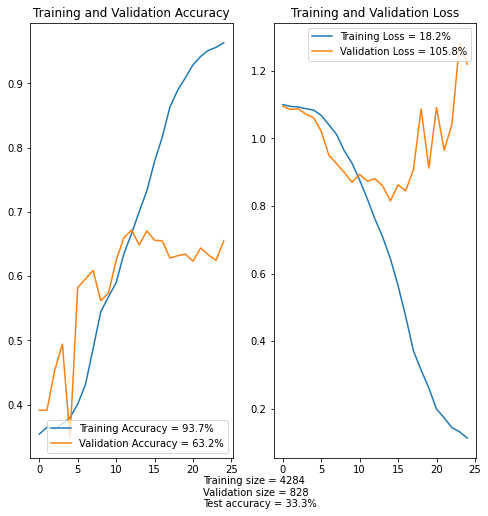

1/1 [==============================] - 0s 23ms/step - loss: 20.4115 - accuracy: 0.3333


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_49_39/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_49_39/assets


Saved model as `augmentgBlur2_23_08_2021__10_49_39`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_23_08_2021__10_53_32 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_53_32/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_53_32/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 85.77it/s]


X_train shape should be: 3584.7
X_train shape: (4284, 200, 200, 1)
X_val and X_test shapes should be: 768.15
X_val shape: (828, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (4284, 3)
y_val shape: (828, 3)
y_test shape: (9, 3)
Epoch 1/50
134/134 [==============================] - 5s 30ms/step - loss: 1.0976 - accuracy: 0.3578 - val_loss: 1.0935 - val_accuracy: 0.3478
Epoch 2/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0957 - accuracy: 0.3595 - val_loss: 1.0899 - val_accuracy: 0.3973
Epoch 3/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0923 - accuracy: 0.3604 - val_loss: 1.0857 - val_accuracy: 0.3478
Epoch 4/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0881 - accuracy: 0.3583 - val_loss: 1.0719 - val_accuracy: 0.3611
Epoch 5/50
134/134 [==============================] - 4s 28ms/step - loss: 1.0742 - accuracy: 0.3658 - val_loss: 1.0502 - val_accuracy: 0.4300
Epoch 6/50
134/134 [=========================

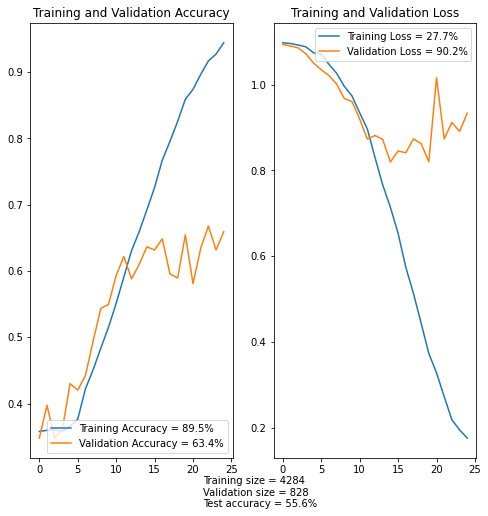

1/1 [==============================] - 0s 18ms/step - loss: 5.5167 - accuracy: 0.5556


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_53_32/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_53_32/assets


Saved model as `augmentgBlur2_23_08_2021__10_53_32`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_23_08_2021__10_56_38 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_56_38/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_23_08_2021__10_56_38/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 104.93it/s]


X_train shape should be: 3584.7
X_train shape: (4284, 200, 200, 1)
X_val and X_test shapes should be: 768.15
X_val shape: (828, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (4284, 3)
y_val shape: (828, 3)
y_test shape: (9, 3)
Epoch 1/50
134/134 [==============================] - 5s 30ms/step - loss: 1.0983 - accuracy: 0.3618 - val_loss: 1.0924 - val_accuracy: 0.3913
Epoch 2/50
134/134 [==============================] - 4s 29ms/step - loss: 1.0925 - accuracy: 0.3611 - val_loss: 1.0856 - val_accuracy: 0.3406
Epoch 3/50
134/134 [==============================] - 4s 29ms/step - loss: 1.0868 - accuracy: 0.3665 - val_loss: 1.0805 - val_accuracy: 0.3345
Epoch 4/50
134/134 [==============================] - 4s 29ms/step - loss: 1.0636 - accuracy: 0.4083 - val_loss: 1.0746 - val_accuracy: 0.3092
Epoch 5/50
134/134 [==============================] - 4s 29ms/step - loss: 1.0222 - accuracy: 0.4559 - val_loss: 1.0532 - val_accuracy: 0.3973
Epoch 6/50
134/134 [=========================

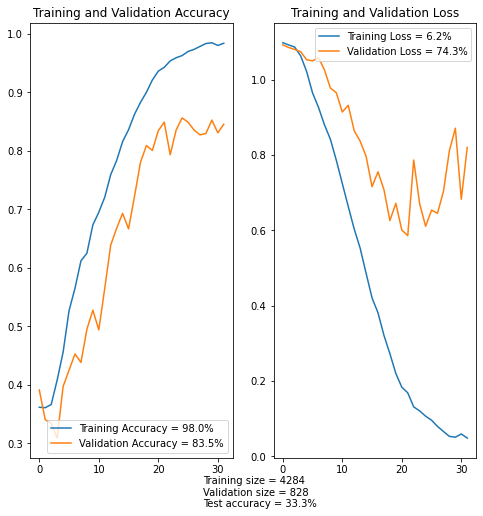

1/1 [==============================] - 0s 18ms/step - loss: 6.9468 - accuracy: 0.3333


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_56_38/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_23_08_2021__10_56_38/assets


Saved model as `augmentgBlur2_23_08_2021__10_56_38`
Average validation accuracy: 70.41999999999999
Average test accuracy: 0.40000001192092893


In [ ]:
augment('gBlur2', gBlur = True, earlyStopping = True, start_point = 0, end_point = 20, increments = 20/2, aug_and_rotate=True)

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_12_08_2021__14_33_25 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_33_25/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_33_25/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus ma

100%|██████████| 3/3 [00:00<00:00, 173.13it/s]


X_train shape should be: 7163.099999999999
X_train shape: (8568, 200, 200, 1)
X_val and X_test shapes should be: 1534.95
X_val shape: (1656, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8568, 3)
y_val shape: (1656, 3)
y_test shape: (9, 3)
Epoch 1/50
268/268 [==============================] - 8s 27ms/step - loss: 1.0986 - accuracy: 0.3577 - val_loss: 1.0994 - val_accuracy: 0.3913
Epoch 2/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0959 - accuracy: 0.4053 - val_loss: 1.0991 - val_accuracy: 0.3913
Epoch 3/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0926 - accuracy: 0.4088 - val_loss: 1.0989 - val_accuracy: 0.4227
Epoch 4/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0879 - accuracy: 0.4237 - val_loss: 1.0994 - val_accuracy: 0.3478
Epoch 5/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0784 - accuracy: 0.4542 - val_loss: 1.1003 - val_accuracy: 0.3671
Epoch 6/50
268/268 [===========

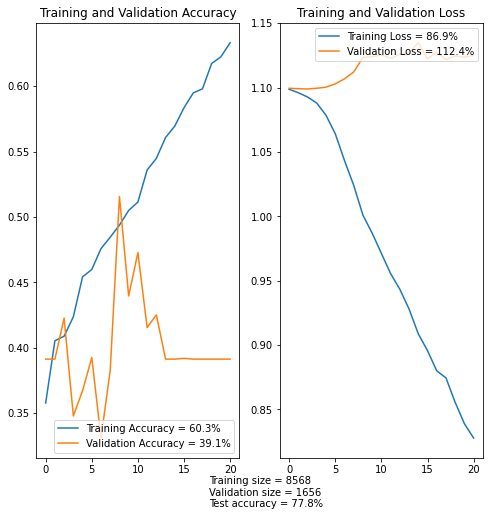

1/1 [==============================] - 0s 24ms/step - loss: 0.7253 - accuracy: 0.7778


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_12_08_2021__14_33_25/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_12_08_2021__14_33_25/assets


Saved model as `augmentgBlur2_12_08_2021__14_33_25`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_12_08_2021__14_39_59 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_39_59/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_39_59/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 65.47it/s]


X_train shape should be: 7163.099999999999
X_train shape: (8568, 200, 200, 1)
X_val and X_test shapes should be: 1534.95
X_val shape: (1656, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8568, 3)
y_val shape: (1656, 3)
y_test shape: (9, 3)
Epoch 1/50
268/268 [==============================] - 8s 27ms/step - loss: 1.0979 - accuracy: 0.3561 - val_loss: 1.0976 - val_accuracy: 0.3478
Epoch 2/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0929 - accuracy: 0.3888 - val_loss: 1.0949 - val_accuracy: 0.3714
Epoch 3/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0872 - accuracy: 0.4142 - val_loss: 1.0916 - val_accuracy: 0.3478
Epoch 4/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0830 - accuracy: 0.4180 - val_loss: 1.0860 - val_accuracy: 0.5217
Epoch 5/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0747 - accuracy: 0.4290 - val_loss: 1.0806 - val_accuracy: 0.4342
Epoch 6/50
268/268 [===========

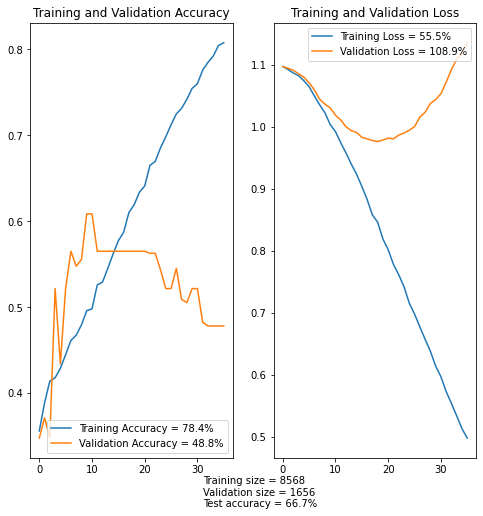

1/1 [==============================] - 0s 26ms/step - loss: 0.7872 - accuracy: 0.6667


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_12_08_2021__14_39_59/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_12_08_2021__14_39_59/assets


Saved model as `augmentgBlur2_12_08_2021__14_39_59`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_12_08_2021__14_48_13 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_48_13/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_48_13/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 85.19it/s]


X_train shape should be: 7163.099999999999
X_train shape: (8568, 200, 200, 1)
X_val and X_test shapes should be: 1534.95
X_val shape: (1656, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8568, 3)
y_val shape: (1656, 3)
y_test shape: (9, 3)
Epoch 1/50
268/268 [==============================] - 8s 27ms/step - loss: 1.0975 - accuracy: 0.3651 - val_loss: 1.0974 - val_accuracy: 0.3913
Epoch 2/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0933 - accuracy: 0.3911 - val_loss: 1.0949 - val_accuracy: 0.3913
Epoch 3/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0904 - accuracy: 0.4017 - val_loss: 1.0911 - val_accuracy: 0.4771
Epoch 4/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0855 - accuracy: 0.4192 - val_loss: 1.0850 - val_accuracy: 0.5622
Epoch 5/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0783 - accuracy: 0.4366 - val_loss: 1.0765 - val_accuracy: 0.5489
Epoch 6/50
268/268 [===========

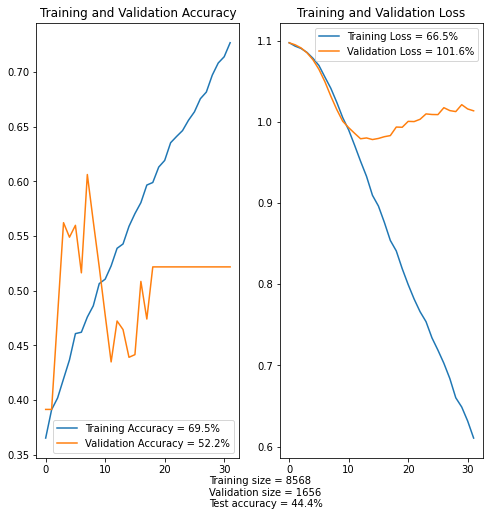

1/1 [==============================] - 0s 26ms/step - loss: 1.0029 - accuracy: 0.4444


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_12_08_2021__14_48_13/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentgBlur2_12_08_2021__14_48_13/assets


Saved model as `augmentgBlur2_12_08_2021__14_48_13`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentgBlur2_12_08_2021__14_56_01 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_56_01/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentgBlur2_12_08_2021__14_56_01/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 29.08it/s]


X_train shape should be: 7163.099999999999
X_train shape: (8568, 200, 200, 1)
X_val and X_test shapes should be: 1534.95
X_val shape: (1656, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8568, 3)
y_val shape: (1656, 3)
y_test shape: (9, 3)
Epoch 1/50
268/268 [==============================] - 8s 27ms/step - loss: 1.0985 - accuracy: 0.3591 - val_loss: 1.0982 - val_accuracy: 0.3913
Epoch 2/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0963 - accuracy: 0.3915 - val_loss: 1.0970 - val_accuracy: 0.3913
Epoch 3/50
268/268 [==============================] - 7s 26ms/step - loss: 1.0935 - accuracy: 0.4004 - val_loss: 1.0950 - val_accuracy: 0.4082
Epoch 4/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0888 - accuracy: 0.4130 - val_loss: 1.0916 - val_accuracy: 0.3913
Epoch 5/50
268/268 [==============================] - 7s 25ms/step - loss: 1.0821 - accuracy: 0.4244 - val_loss: 1.0860 - val_accuracy: 0.4239
Epoch 6/50
268/268 [===========

KeyboardInterrupt: ignored

In [ ]:
augment('gBlur2', gBlur = True, earlyStopping = True, start_point = 0, end_point = 30, increments = 30/72)

# Salt and pepper results

Text(0.725, 0.15, '50% salt and pepper')

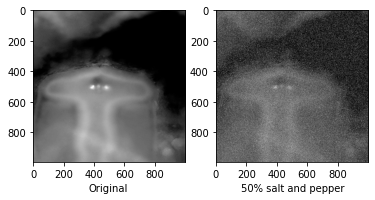

In [ ]:
og = cv2.imread(path + '/labeled_data/10_3/10.3_040.jpg', cv2.IMREAD_GRAYSCALE)
SP10 = iaa.SaltAndPepper(0)
SP20 = iaa.SaltAndPepper(0.3)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(SP10(image = og), cmap = 'gray')
f.text(0.3,0.15, 'Original', ha = 'center', va = 'center')
axarr[1].imshow(SP20(image = og), cmap = 'gray')
f.text(0.725,0.15, '50% salt and pepper', ha = 'center', va = 'center')

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentsaltandpepper_12_08_2021__15_54_28 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentsaltandpepper_12_08_2021__15_54_28/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentsaltandpepper_12_08_2021__15_54_28/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIu

100%|██████████| 3/3 [00:00<00:00, 82.75it/s]


X_train shape should be: 14916.3
X_train shape: (17850, 200, 200, 1)
X_val and X_test shapes should be: 3196.35
X_val shape: (3450, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (17850, 3)
y_val shape: (3450, 3)
y_test shape: (9, 3)
Epoch 1/50
558/558 [==============================] - 16s 27ms/step - loss: 0.8991 - accuracy: 0.5286 - val_loss: 0.7890 - val_accuracy: 0.6351
Epoch 2/50
558/558 [==============================] - 14s 26ms/step - loss: 0.1575 - accuracy: 0.9429 - val_loss: 0.9768 - val_accuracy: 0.6423
Epoch 3/50
558/558 [==============================] - 14s 25ms/step - loss: 0.0309 - accuracy: 0.9910 - val_loss: 1.3589 - val_accuracy: 0.6725
Epoch 4/50
558/558 [==============================] - 14s 26ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 1.5986 - val_accuracy: 0.6574
Epoch 5/50
558/558 [==============================] - 14s 25ms/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 1.9839 - val_accuracy: 0.6354
Epoch 6/50
558/558 [==============

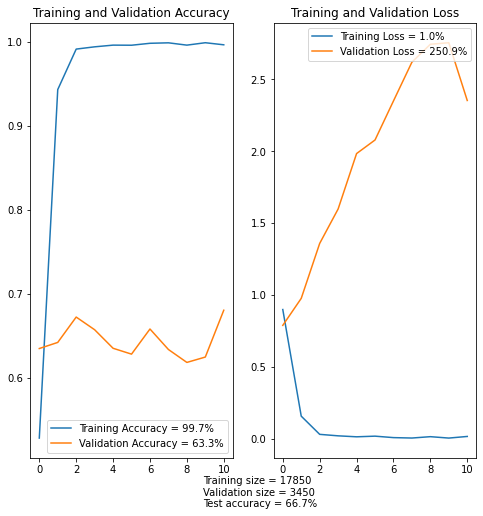

1/1 [==============================] - 0s 23ms/step - loss: 0.5785 - accuracy: 0.6667


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentsaltandpepper_12_08_2021__15_54_28/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentsaltandpepper_12_08_2021__15_54_28/assets


Saved model as `augmentsaltandpepper_12_08_2021__15_54_28`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentsaltandpepper_12_08_2021__16_09_43 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentsaltandpepper_12_08_2021__16_09_43/train/10_1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-207-68c95da48c2e>", line 1, in <module>
    augment('saltandpepper', sp = True, earlyStopping = True, start_point = 0, end_point = 0.3, increments = 0.5/250)
  File "<ipython-input-193-65ca612af3fc>", line 177, in augment
    aug_img = aug(image = image)
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py", line 2027, in __call__
    return self.augment(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py", line 1998, in augment
    batch_aug = self.augment_batch_(batch, hooks=hooks)
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py", line 647, in augment_batch_
    hooks=hooks)
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/arithmetic.py", line 3803, in _augment_batch_
    r

KeyboardInterrupt: ignored

In [ ]:
augment('saltandpepper', sp = True, earlyStopping = True, start_point = 0, end_point = 0.3, increments = 0.5/250)

# Cutout results

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no cutout1 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/cutout1/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/cutout1/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/cutout1/train/10_3
/content/drive/.shortcut-targets-by-id/1Zb

100%|██████████| 3/3 [00:00<00:00, 43.95it/s]


X_train shape should be: 7262.499999999999
X_train shape: (8687, 200, 200, 1)
X_val and X_test shapes should be: 1556.25
X_val shape: (1679, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8687, 3)
y_val shape: (1679, 3)
y_test shape: (9, 3)
Epoch 1/50
272/272 [==============================] - 9s 28ms/step - loss: 1.1347 - accuracy: 0.4324 - val_loss: 1.1469 - val_accuracy: 0.4288
Epoch 2/50
272/272 [==============================] - 7s 26ms/step - loss: 1.0542 - accuracy: 0.4913 - val_loss: 1.1283 - val_accuracy: 0.4163
Epoch 3/50
272/272 [==============================] - 7s 26ms/step - loss: 0.9913 - accuracy: 0.5382 - val_loss: 1.1159 - val_accuracy: 0.4312
Epoch 4/50
272/272 [==============================] - 7s 26ms/step - loss: 0.9252 - accuracy: 0.5921 - val_loss: 1.1082 - val_accuracy: 0.4378
Epoch 5/50
272/272 [==============================] - 7s 26ms/step - loss: 0.8703 - accuracy: 0.6292 - val_loss: 1.0814 - val_accuracy: 0.4854
Epoch 6/50
272/272 [===========

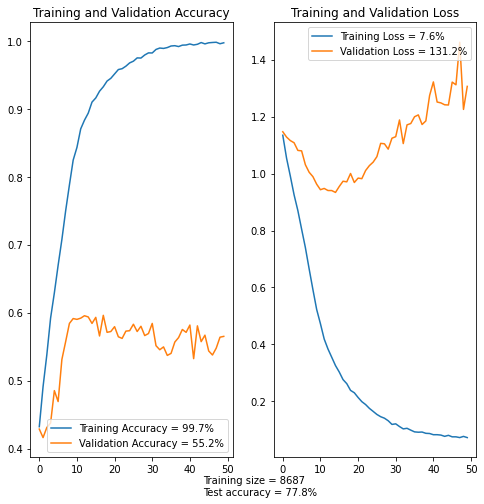

INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/cutout1_09_08_2021__10_27/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/cutout1_09_08_2021__10_27/assets


Saved model as `cutout1_09_08_2021__10_27`


In [ ]:
augment('cutout1', cutout = True)

# Shear results

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentshear2_12_08_2021__11_01_00 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentshear2_12_08_2021__11_01_00/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentshear2_12_08_2021__11_01_00/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus ma

100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


X_train shape should be: 28633.5
X_train shape: (34272, 200, 200, 1)
X_val and X_test shapes should be: 6135.75
X_val shape: (6624, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (34272, 3)
y_val shape: (6624, 3)
y_test shape: (9, 3)
Epoch 1/50
1071/1071 [==============================] - 29s 26ms/step - loss: 0.5353 - accuracy: 0.7453 - val_loss: 3.3793 - val_accuracy: 0.4786
Epoch 2/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0339 - accuracy: 0.9902 - val_loss: 5.4294 - val_accuracy: 0.4704
Epoch 3/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 5.5302 - val_accuracy: 0.5166
Epoch 4/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0145 - accuracy: 0.9964 - val_loss: 6.7774 - val_accuracy: 0.4864
Epoch 5/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 7.1763 - val_accuracy: 0.4837
Epoch 6/50
1/1 [========

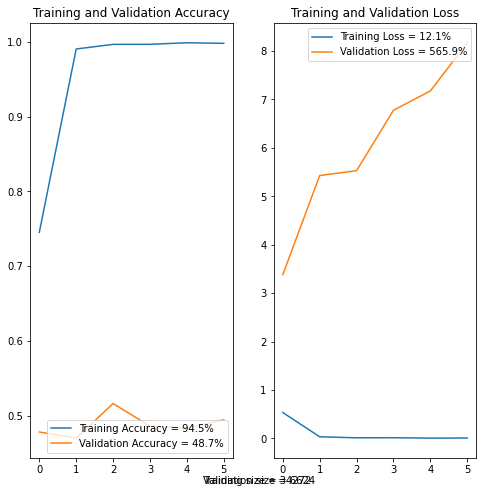

1/1 [==============================] - 0s 22ms/step - loss: 10.0544 - accuracy: 0.5556


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentshear2_12_08_2021__11_01_00/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentshear2_12_08_2021__11_01_00/assets


Saved model as `augmentshear2_12_08_2021__11_01_00`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentshear2_12_08_2021__11_16_03 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentshear2_12_08_2021__11_16_03/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentshear2_12_08_2021__11_16_03/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 114.78it/s]


X_train shape should be: 28633.5
X_train shape: (34272, 200, 200, 1)
X_val and X_test shapes should be: 6135.75
X_val shape: (6624, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (34272, 3)
y_val shape: (6624, 3)
y_test shape: (9, 3)
Epoch 1/50
1071/1071 [==============================] - 29s 26ms/step - loss: 0.5221 - accuracy: 0.7491 - val_loss: 2.6148 - val_accuracy: 0.4164
Epoch 2/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 3.1465 - val_accuracy: 0.4891
Epoch 3/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 3.3788 - val_accuracy: 0.5205
Epoch 4/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 4.2006 - val_accuracy: 0.4873
Epoch 5/50
1071/1071 [==============================] - 27s 25ms/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 4.6130 - val_accuracy: 0.5112
Epoch 6/50
1/1 [========

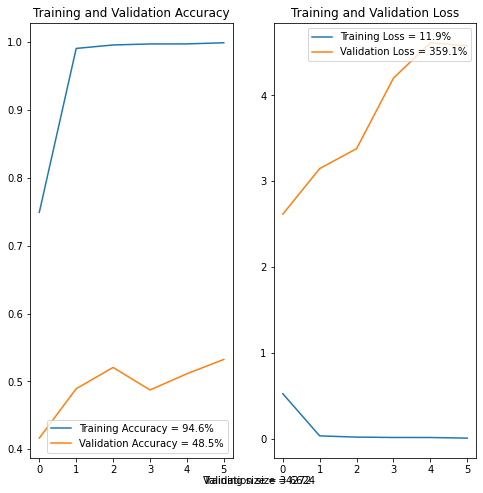

1/1 [==============================] - 0s 22ms/step - loss: 5.1082 - accuracy: 0.5556


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentshear2_12_08_2021__11_16_03/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentshear2_12_08_2021__11_16_03/assets


Saved model as `augmentshear2_12_08_2021__11_16_03`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentshear2_12_08_2021__11_30_26 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentshear2_12_08_2021__11_30_26/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentshear2_12_08_2021__11_30_26/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-

100%|██████████| 3/3 [00:00<00:00, 82.35it/s]


In [ ]:
augment('shear2', Shear = True, earlyStopping = True)

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentcombination_16_08_2021__10_40_22 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcombination_16_08_2021__10_40_22/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcombination_16_08_2021__10_40_22/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/

100%|██████████| 3/3 [00:00<00:00, 169.26it/s]


X_train shape should be: 5373.9
X_train shape: (6426, 200, 200, 1)
X_val and X_test shapes should be: 1151.55
X_val shape: (1242, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (6426, 3)
y_val shape: (1242, 3)
y_test shape: (9, 3)
Epoch 1/50
201/201 [==============================] - 21s 27ms/step - loss: 1.0989 - accuracy: 0.3413 - val_loss: 1.0991 - val_accuracy: 0.3486
Epoch 2/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0963 - accuracy: 0.3618 - val_loss: 1.0989 - val_accuracy: 0.3478
Epoch 3/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0939 - accuracy: 0.3791 - val_loss: 1.0984 - val_accuracy: 0.3470
Epoch 4/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0913 - accuracy: 0.3707 - val_loss: 1.0976 - val_accuracy: 0.3382
Epoch 5/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0891 - accuracy: 0.3858 - val_loss: 1.0968 - val_accuracy: 0.3374
Epoch 6/50
201/201 [=====================

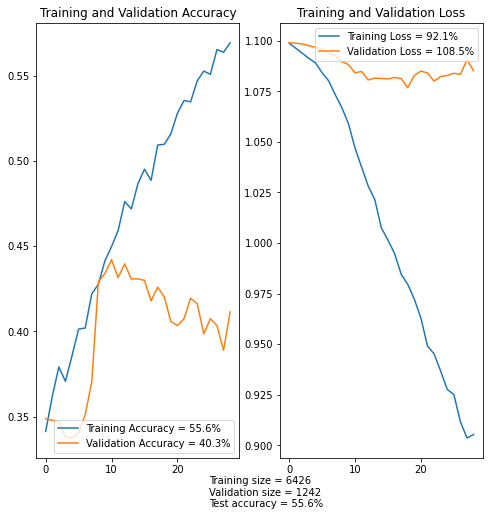

1/1 [==============================] - 0s 17ms/step - loss: 0.9662 - accuracy: 0.5556


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentcombination_16_08_2021__10_40_22/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentcombination_16_08_2021__10_40_22/assets


Saved model as `augmentcombination_16_08_2021__10_40_22`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentcombination_16_08_2021__10_46_43 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcombination_16_08_2021__10_46_43/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcombination_16_08_2021__10_46_43/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.

100%|██████████| 3/3 [00:00<00:00, 71.52it/s]


X_train shape should be: 5373.9
X_train shape: (6426, 200, 200, 1)
X_val and X_test shapes should be: 1151.55
X_val shape: (1242, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (6426, 3)
y_val shape: (1242, 3)
y_test shape: (9, 3)
Epoch 1/50
201/201 [==============================] - 6s 26ms/step - loss: 1.0989 - accuracy: 0.3575 - val_loss: 1.0979 - val_accuracy: 0.3873
Epoch 2/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0974 - accuracy: 0.3711 - val_loss: 1.0971 - val_accuracy: 0.4211
Epoch 3/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0962 - accuracy: 0.3816 - val_loss: 1.0961 - val_accuracy: 0.4380
Epoch 4/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0946 - accuracy: 0.3813 - val_loss: 1.0950 - val_accuracy: 0.4300
Epoch 5/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0930 - accuracy: 0.3870 - val_loss: 1.0934 - val_accuracy: 0.4050
Epoch 6/50
201/201 [======================

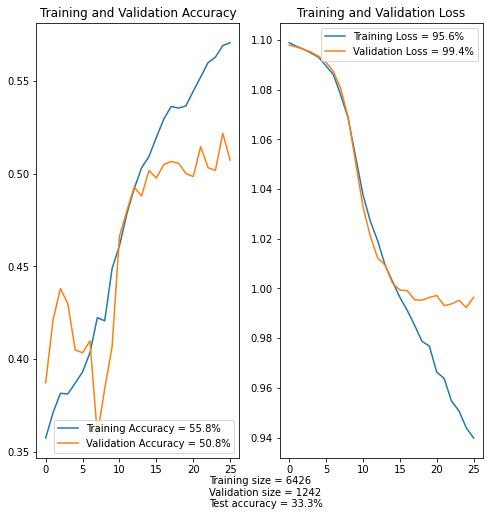

1/1 [==============================] - 0s 17ms/step - loss: 1.1449 - accuracy: 0.3333


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentcombination_16_08_2021__10_46_43/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/augmentcombination_16_08_2021__10_46_43/assets


Saved model as `augmentcombination_16_08_2021__10_46_43`
Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no augmentcombination_16_08_2021__10_50_07 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcombination_16_08_2021__10_50_07/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/augmentcombination_16_08_2021__10_50_07/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.

100%|██████████| 3/3 [00:00<00:00, 153.54it/s]


X_train shape should be: 5373.9
X_train shape: (6426, 200, 200, 1)
X_val and X_test shapes should be: 1151.55
X_val shape: (1242, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (6426, 3)
y_val shape: (1242, 3)
y_test shape: (9, 3)
Epoch 1/50
201/201 [==============================] - 6s 26ms/step - loss: 1.1015 - accuracy: 0.3559 - val_loss: 1.0957 - val_accuracy: 0.3430
Epoch 2/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0921 - accuracy: 0.3791 - val_loss: 1.0933 - val_accuracy: 0.3438
Epoch 3/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0885 - accuracy: 0.3900 - val_loss: 1.0905 - val_accuracy: 0.3816
Epoch 4/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0861 - accuracy: 0.3970 - val_loss: 1.0879 - val_accuracy: 0.3905
Epoch 5/50
201/201 [==============================] - 5s 25ms/step - loss: 1.0775 - accuracy: 0.4216 - val_loss: 1.0837 - val_accuracy: 0.4404
Epoch 6/50
201/201 [======================

KeyboardInterrupt: ignored

In [ ]:
augment('combination', cutout = True, flip = True, start_point=0, end_point=0, increments = 50, n_iter = 10, earlyStopping=True)

# Results using rotated images as base

Folders removed
Total images:  54
Training:  43
Validation:  8
Testing:  3
Total images:  55
Training:  43
Validation:  9
Testing:  3
Total images:  42
Training:  33
Validation:  6
Testing:  3
no croprot4 folder to clear
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/croprot4/train/10_1
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/croprot4/train/10_2
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/train/10_3
/content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Data/croprot4/train/10_3
/content/drive/.shortcut-targets-by-id

100%|██████████| 3/3 [00:00<00:00, 111.35it/s]


X_train shape should be: 7163.099999999999
X_train shape: (8568, 200, 200, 1)
X_val and X_test shapes should be: 1534.95
X_val shape: (1656, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8568, 3)
y_val shape: (1656, 3)
y_test shape: (9, 3)
Epoch 1/50
268/268 [==============================] - 24s 28ms/step - loss: 1.1635 - accuracy: 0.3688 - val_loss: 1.1596 - val_accuracy: 0.4680
Epoch 2/50
268/268 [==============================] - 7s 26ms/step - loss: 1.1596 - accuracy: 0.3904 - val_loss: 1.1574 - val_accuracy: 0.4130
Epoch 3/50
268/268 [==============================] - 7s 26ms/step - loss: 1.1553 - accuracy: 0.3982 - val_loss: 1.1523 - val_accuracy: 0.4680
Epoch 4/50
268/268 [==============================] - 7s 26ms/step - loss: 1.1496 - accuracy: 0.3983 - val_loss: 1.1506 - val_accuracy: 0.3853
Epoch 5/50
268/268 [==============================] - 7s 26ms/step - loss: 1.1424 - accuracy: 0.4258 - val_loss: 1.1433 - val_accuracy: 0.4016
Epoch 6/50
268/268 [==========

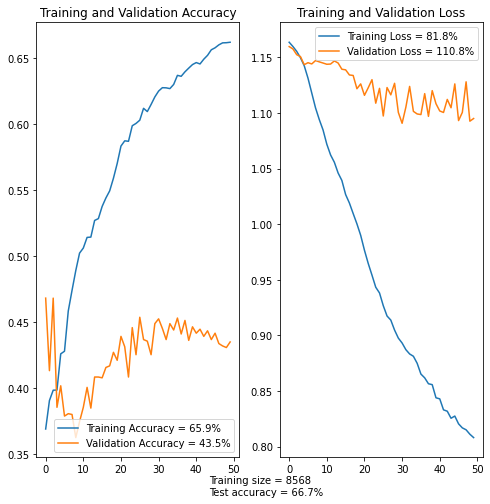

INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/croprot4_09_08_2021__14_28/assets


INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1ZbnJPWEDz_tPFpcEvBWPaS5XZIuj7-E3/Hypothalamus machine learning/Models/croprot4_09_08_2021__14_28/assets


Saved model as `croprot4_09_08_2021__14_28`


In [ ]:
augment('croprot4', Crop = True, aug_and_rotate = True)

# Using test rot

In [ ]:
import zipfile
!unzip '/content/test_rot.zip'

Streaming output truncated to the last 5000 lines.
  inflating: test_rot/train/10_2/190test_rot10.2_017.jpg  
  inflating: test_rot/train/10_1/170test_rot10.1_030.jpg  
  inflating: test_rot/train/10_2/210test_rot10.2_017.jpg  
  inflating: test_rot/train/10_2/180test_rot10.2_017.jpg  
  inflating: test_rot/train/10_1/160test_rot10.1_030.jpg  
  inflating: test_rot/train/10_2/185test_rot10.2_017.jpg  
  inflating: test_rot/train/10_1/150test_rot10.1_030.jpg  
  inflating: test_rot/train/10_1/175test_rot10.1_030.jpg  
  inflating: test_rot/train/10_2/175test_rot10.2_017.jpg  
  inflating: test_rot/train/10_1/180test_rot10.1_030.jpg  
  inflating: test_rot/train/10_2/195test_rot10.2_017.jpg  
  inflating: test_rot/train/10_1/155test_rot10.1_030.jpg  
  inflating: test_rot/train/10_2/170test_rot10.2_017.jpg  
  inflating: test_rot/train/10_1/165test_rot10.1_030.jpg  
  inflating: test_rot/train/10_1/145test_rot10.1_030.jpg  
  inflating: test_rot/train/10_1/140test_rot10.1_030.jpg  
  inf

In [ ]:
import tqdm
def create_training_data(directory_name, train = False, val = False, test = False):
    training_data = []
    val_data = []
    test_data = []
    for category in CATEGORIES:  # 10_1, 10_2, 10_3

        path = os.path.join(directory_name,category) 
        class_num = CATEGORIES.index(category)  # get the label  (0, 1 or 2)

        for img in tqdm.tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) 
                if train == True:
                  training_data.append([cv2.resize(img_array, (200, 200)), class_num])
                if val == True:
                  val_data.append([cv2.resize(img_array, (200, 200)), class_num])
                if test == True:
                  test_data.append([cv2.resize(img_array, (200, 200)), class_num])
            except Exception as e:  
                pass

    if train == True:
      return training_data

    if val == True:
      return val_data

    if test == True:
      return test_data

In [ ]:
training_data = create_training_data('test_rot/train', train = True)
val_data = create_training_data('test_rot/val', val = True)
test_data = create_training_data(path + '/test', test = True)

100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


In [ ]:
    random.shuffle(training_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    # Preprocessing the data into X_train etc with relevant input shapes
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    img_size = 200

    for feature, label in training_data:
      X_train.append(feature)
      y_train.append(label)

    for feature, label in val_data:
      X_val.append(feature)
      y_val.append(label)

    for feature, label in test_data:
      X_test.append(feature)
      y_test.append(label)

    X_train = np.array(X_train) / 255
    X_val = np.array(X_val) / 255
    X_test = np.array(X_test) / 255

    X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
    X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
    X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

    X_train.astype('float32')
    X_val.astype('float32')
    X_test.astype('float32')

    y_train=to_categorical(y_train)
    y_val=to_categorical(y_val)
    y_test = to_categorical(y_test)

    print('X_train shape should be:', 0.7*(len(training_data) + len(test_data) + len(val_data)))
    print('X_train shape:', np.shape(X_train))
    print('X_val and X_test shapes should be:', 0.15*(len(training_data) + len(test_data) + len(val_data)))
    print('X_val shape:', np.shape(X_val))
    print('X_test shape:', np.shape(X_test))
    print('y_train shape:', np.shape(y_train))
    print('y_val shape:', np.shape(y_val))
    print('y_test shape:', np.shape(y_test))

X_train shape should be: 7163.799999999999
X_train shape: (8065, 200, 200, 1)
X_val and X_test shapes should be: 1535.1
X_val shape: (2160, 200, 200, 1)
X_test shape: (9, 200, 200, 1)
y_train shape: (8065, 3)
y_val shape: (2160, 3)
y_test shape: (9, 3)


In [ ]:
from datetime import datetime
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Augmentation function
def augment2(flip = False):
              #augmentation_name,
#             start_point = 0.0,
#             end_point = 0.0,
#             increments = 0.0,
#             n_iter = 5,
#             rotate = False,
            #flip = False,
            # Crop = False,
            # Shear = False,
            # Skew = False,
            # Warp = False,
            # gBlur = False,
            # bright = False,
            # sat = False,
            # cont = False,
            # sp = False,
            # cutout = False,
            # no_aug = False,
            # aug_and_rotate = False,
            # earlyStopping = False,
            #):
  val_accuracies = []
  test_accuracies = []
  aug_train = []
  aug_val = []
  now = datetime.now()
  save_name = 'augment' + '{}'.format(augmentation_name) + now.strftime("_%d_%m_%Y__%H_%M_%S")


  create_directory(path = path, 
                dir_name = save_name)
  sets = [training_data, val_data]
  for image in training_data:
      if flip == True:
        aug_train.append(cv2.resize(image, (200, 200)))
        aug_train.append(cv2.resize(cv2.flip(image, 0), (200, 200)))
        aug_train.append(cv2.resize(cv2.flip(image, 1), (200, 200)))
        aug_train.append(cv2.resize(cv2.flip(image, -1), (200, 200)))
  for image in val_data:
      if flip == True:
        aug_val.append(cv2.resize(image, (200, 200)))
        aug_val.append(cv2.resize(cv2.flip(image, 0), (200, 200)))
        aug_val.append(cv2.resize(cv2.flip(image, 1), (200, 200)))
        aug_val.append(cv2.resize(cv2.flip(image, -1), (200, 200)))

              # if Crop == True:
              #   for percentage in np.arange(start_point, end_point, increments):
              #     crop = iaa.Crop(percent = percentage, keep_size = True)
              #     image_aug = crop(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 20):
              #         aug = imutils.rotate_bound(image_aug ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(percentage) +'rotated_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(image_aug, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(percentage) + 'crop{}.jpg'.format(fn), resize)

              # if Shear == True:
              #   for num in np.arange(start_point, end_point, increments):
              #     shear = iaa.ShearX(num)
              #     image_aug = shear(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(image_aug ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotated_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(image_aug, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(num) + 'shearX{}.jpg'.format(fn), resize)

              #     shear2 = iaa.ShearY(num)
              #     image_aug2 = shear(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(image_aug ,angle)
              #         resize2 = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotated_{}.jpg'.format(fn), resize2)
              #     else:
              #       resize2 = cv2.resize(image_aug, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(num) + 'shearY{}.jpg'.format(fn), resize2)
                  

              # if gBlur == True:
              #   for num in np.arange(start_point, end_point, increments):
              #     gblur = iaa.GaussianBlur(sigma = num)
              #     image_aug = gblur(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(image_aug ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotatedblur_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(image_aug, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(num) + 'blur{}.jpg'.format(fn), resize)

              # if bright == True:
              #   for brightness in np.arange(start_point, end_point, increments):
              #     brighten = iaa.MultiplyBrightness(brightness)
              #     brightened = brighten(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(brightened ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(brightness) +'rotatedbright_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(brightened, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(brightness) + 'bright{}.jpg'.format(fn), resize)

              # if sat == True:
              #   for saturation in np.arange(start_point, end_point, increments):
              #     saturate = iaa.MultiplySaturation(saturation)
              #     saturated_img = saturate(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(saturated_img ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(saturation) +'rotatedsat_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(saturated_img, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(saturation) + 'sat{}.jpg'.format(fn), resize)

              # if cont == True:
              #   for contrast in np.arange(start_point, end_point, increments):
              #     aug = iaa.GammaContrast(contrast)
              #     contrast_img = aug(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(contrast_img ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(contrast) +'rotatedcont_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(constrast_img, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(contrast) + 'cont{}.jpg'.format(fn), resize)

              # if sp == True:
              #   for num in np.arange(start_point, end_point, increments):
              #     aug = iaa.SaltAndPepper(num)
              #     aug_img = aug(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(aug_img ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(num) +'rotatedSP_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(aug_img, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(num) + 'SP{}.jpg'.format(fn), resize)

              
              # if cutout == True:
              #   resize = cv2.resize(image,(200,200))
              #   cv2.imwrite(destination_path +'/{}.jpg'.format(fn), resize)

              #   for i in range(increments):
              #     aug = iaa.Cutout()
              #     aug_img = aug(image = image)
              #     if aug_and_rotate == True:
              #       for angle in np.arange(0, 360, 5):
              #         aug = imutils.rotate_bound(aug_img ,angle)
              #         resize = cv2.resize(aug,(200,200))
              #         cv2.imwrite(destination_path + '/{}'.format(angle) + '{}'.format(i) +'rotatedcut_{}.jpg'.format(fn), resize)
              #     else:
              #       resize = cv2.resize(aug_img, (200, 200))
              #       cv2.imwrite(destination_path + '/{}'.format(i) + 'cut{}.jpg'.format(fn), resize)

#       os.chdir(os.path.join(os.path.dirname(raw_path)))

#   training_data, val_data, test_data = data(path = path,
#                               dir_name = save_name)

#   random.shuffle(training_data)
#   random.shuffle(val_data)
#   random.shuffle(test_data)

#   # Preprocessing the data into X_train etc with relevant input shapes
#   X_train = []
#   y_train = []
#   X_val = []
#   y_val = []
#   X_test = []
#   y_test = []
#   img_size = 200

#   for feature, label in training_data:
#     X_train.append(feature)
#     y_train.append(label)

#   for feature, label in val_data:
#     X_val.append(feature)
#     y_val.append(label)

#   for feature, label in test_data:
#     X_test.append(feature)
#     y_test.append(label)

#   X_train = np.array(X_train) / 255
#   X_val = np.array(X_val) / 255
#   X_test = np.array(X_test) / 255

#   X_train = X_train.reshape(X_train.shape[0], 200, 200, 1)
#   X_val = X_val.reshape(X_val.shape[0], 200, 200, 1)
#   X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)

#   X_train.astype('float32')
#   X_val.astype('float32')
#   X_test.astype('float32')

#   y_train=to_categorical(y_train)
#   y_val=to_categorical(y_val)
#   y_test = to_categorical(y_test)

#   print('X_train shape should be:', 0.7*(len(training_data) + len(test_data) + len(val_data)))
#   print('X_train shape:', np.shape(X_train))
#   print('X_val and X_test shapes should be:', 0.15*(len(training_data) + len(test_data) + len(val_data)))
#   print('X_val shape:', np.shape(X_val))
#   print('X_test shape:', np.shape(X_test))
#   print('y_train shape:', np.shape(y_train))
#   print('y_val shape:', np.shape(y_val))
#   print('y_test shape:', np.shape(y_test))

#   layer_drop = 0.07154743824929628
#   final_drop = 0.9226848150860136
#   lamda = 1.1209101215526163e-06
#   activation = 'relu'
#   model = Sequential([
#     layers.Conv2D(16, 3, 
#                   padding='same', 
#                   activation=activation, 
#                   input_shape = (200, 200, 1), 
#                   kernel_regularizer=regularizers.l2(lamda), 
#                   name = 'conv-layer-1'),
#     layers.Dropout(layer_drop),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, 
#                   padding='same', 
#                   activation=activation, 
#                   kernel_regularizer=regularizers.l2(lamda), 
#                   name = 'conv-layer-2'),
#     layers.Dropout(layer_drop),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, 
#                   padding='same', 
#                   activation=activation, 
#                   kernel_regularizer=regularizers.l2(lamda),
#                   name = 'conv-layer-3'),
#     layers.Dropout(layer_drop),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, 
#                   padding='same', 
#                   activation=activation, 
#                   kernel_regularizer=regularizers.l2(lamda), 
#                   name = 'conv-layer-4'),
#     layers.Dropout(layer_drop),
#     layers.MaxPooling2D(),
#     layers.Conv2D(256, 3, 
#                   padding='same', 
#                   activation=activation, 
#                   kernel_regularizer=regularizers.l2(lamda), 
#                   name = 'conv-layer-5'),
#     layers.Dropout(layer_drop),
#     layers.Conv2D(512, 3, 
#                   padding='same', 
#                   activation=activation, 
#                   kernel_regularizer=regularizers.l2(lamda), 
#                   name = 'conv-layer-6'),
#     layers.Dropout(layer_drop),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(final_drop),
#     layers.Dense(3, activation = 'softmax')
#   ])

#   optimizer = Adam(learning_rate = 0.0000020465927460995575)
#   model.compile(optimizer = optimizer,
#                 loss = 'categorical_crossentropy',
#                 metrics = ['accuracy'])
  
#   epochs = 50
#   if earlyStopping == True:
#     earlyStop = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10)

#     history = model.fit(x=X_train,
#                       y=y_train,
#                       epochs=epochs,
#                       batch_size=32,
#                       validation_data=(X_val, y_val),
#                       callbacks = [earlyStop])
#     if earlyStop.stopped_epoch < epochs:
#       epochs_range = range(earlyStop.stopped_epoch+1)

#   else:
#     history = model.fit(x=X_train,
#                       y=y_train,
#                       epochs=epochs,
#                       batch_size=32,
#                       validation_data=(X_val, y_val))
#     epochs_range = range(epochs)


#   acc = history.history['accuracy']
#   val_acc = history.history['val_accuracy']
#   loss = history.history['loss']
#   val_loss = history.history['val_loss']
#   accuracy = history.history['val_accuracy'][-1]

#   # Test accuracy
#   test_acc = model.evaluate(X_test, y_test)[1]

#   # if callback.stopped_epoch < epochs:
#   #   epochs_range = range(callback.stopped_epoch + 1)
#   # else:
#   #   epochs_range = range(epochs)


#   plt.figure(figsize=(8, 8))
#   plt.subplot(1, 2, 1)
#   plt.plot(epochs_range, acc, label='Training Accuracy = {}%'.format(round(np.mean(acc[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
#   plt.plot(epochs_range, val_acc, label='Validation Accuracy = {}%'.format(round(np.mean(val_acc[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
#   plt.legend(loc='lower right')
#   plt.title('Training and Validation Accuracy')

#   plt.subplot(1, 2, 2)
#   plt.plot(epochs_range, loss, label='Training Loss = {}%'.format(round(np.mean(loss[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
#   plt.plot(epochs_range, val_loss, label='Validation Loss = {}%'.format(round(np.mean(val_loss[max(epochs_range) - 5:max(epochs_range)])*100, 1)))
#   plt.legend(loc='upper right')
#   plt.title('Training and Validation Loss')
#   plt.figtext(0.425, 0.08, 'Training size = {}'.format(np.shape(X_train)[0]))
#   plt.figtext(0.425, 0.06, 'Validation size = {}'.format(np.shape(X_val)[0]))
#   plt.figtext(0.425, 0.04, 'Test accuracy = {}%'.format(round(test_acc*100, 1)))
#   plt.savefig(plotDIR + '/{}.png'.format(save_name))
#   print('Saved plot as `{}`.png'.format(save_name))
#   plt.show()

#   val_accuracies.append(round(np.mean(val_acc[max(epochs_range) - 5:max(epochs_range)])*100, 1))
#   test_accuracies.append(model.evaluate(X_test, y_test)[1])

#   # if accuracy > best_accuracy:

#   #     model.save(path_best_model)

#   #     best_accuracy = accuracy

#   model.save(modelDIR + '/{}'.format(save_name))
#   print('Saved model as `{}`'.format(save_name))

#   del model

#   K.clear_session()

# print('Average validation accuracy:', np.mean(val_accuracies))
# print('Average test accuracy:', np.mean(test_accuracies))



In [ ]:
def augment2(flip = False):
  aug_train = []
  aug_val = []
  for image in training_data:
      if flip == True:
        aug_train.append(cv2.resize(image, (200, 200)))
        aug_train.append(cv2.resize(cv2.flip(image, 0), (200, 200)))
        aug_train.append(cv2.resize(cv2.flip(image, 1), (200, 200)))
        aug_train.append(cv2.resize(cv2.flip(image, -1), (200, 200)))
  for image in val_data:
      if flip == True:
        aug_val.append(cv2.resize(image, (200, 200)))
        aug_val.append(cv2.resize(cv2.flip(image, 0), (200, 200)))
        aug_val.append(cv2.resize(cv2.flip(image, 1), (200, 200)))
        aug_val.append(cv2.resize(cv2.flip(image, -1), (200, 200)))

In [ ]:
def aug(flip = False):
  aug_train = []
  aug_val = []
  for feature, label in training_data:
     X_train.append(feature)
     y_train.append(label)
  for img in X_train:
    if flip == True:
      image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
      np.append(aug_train, cv2.resize(cv2.flip(image, 0), (200, 200)))
    else:
      pass

In [ ]:
aug(flip=True)

AttributeError: ignored

In [ ]:
training_data[0][1]

1